In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose,Activation,add,multiply
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import regularizers
from keras.layers.merge import concatenate
from keras.layers.core import Lambda

Using TensorFlow backend.
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poudelas/anaco

In [2]:
import tensorflow as tf

In [15]:
im_width = 224
im_height = 224
border = 5
path_train = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/train1/'
path_test = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/test1/'

In [6]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from efficientnet.keras import center_crop_and_resize, preprocess_input
# seed = 1 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
# image_datagen = ImageDataGenerator(preprocess_input,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                  ) # custom fuction for each image you can use resnet one too.
# mask_datagen = ImageDataGenerator(width_shift_range=0.1,
#                  height_shift_range=0.1,
                 
#                  )  # to make mask as feedable formate (256,256,1)

# image_generator =image_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/train/image",
#                                                     class_mode=None, seed=seed,
#                                                     target_size = (224, 224))

# mask_generator = mask_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/train/mask/",
#                                                    class_mode=None, 
#                                                    seed=seed,
#                                                    target_size = (224, 224))

# train_generator = zip(image_generator, mask_generator)

Found 795 images belonging to 1 classes.
Found 795 images belonging to 1 classes.


In [7]:
# valid_generator_image =image_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/validation/image",
#                                                     class_mode=None, seed=seed)

# valid_mask_generator = mask_datagen.flow_from_directory("/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/validation/mask/",
#                                                    class_mode=None, seed=seed)

# valid_generator = zip(valid_generator_image, valid_mask_generator)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [16]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "image"))[2]
    X = np.zeros((len(ids), 224, 224, 3), dtype=np.uint8)
    y = np.zeros((len(ids), 224, 224, 1), dtype=np.bool)
  
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        #img = load_img(path + '/image/' + id_, grayscale=False)
        img = imread(path + '/image/' + id_)[:,:,:3]
        img = resize(img, (224, 224), mode='constant', preserve_range=True)
        #X[n] = img
        
        mask = img_to_array(load_img(path + 'mask/'+id_, grayscale=True))
        mask = resize(mask, (224, 224, 1), mode = 'constant', preserve_range = True)
        
        X[n] = img
        y[n] = mask
        
#         mask_ = imread(path + '/mask/' + id_)
#         mask_ = np.expand_dims(resize(mask_, (224, 224), mode='constant', 
#                                           preserve_range=True), axis=-1)
#         print(mask_.shape)
#         print(y.shape)
#         mask = np.maximum(y, mask_)
            
#         y[n]=mask_
        
    return X,y

In [17]:
X_train, Y_train = get_data(path_train, train=True)

Getting and resizing images ... 


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [18]:
BATCH_SIZE = 10
seed = 1
from keras.preprocessing import image
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

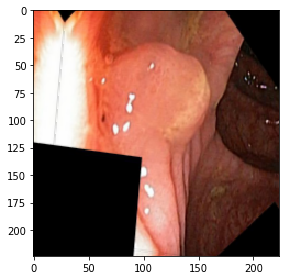

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


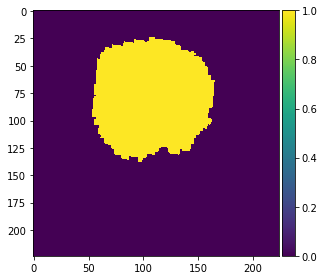

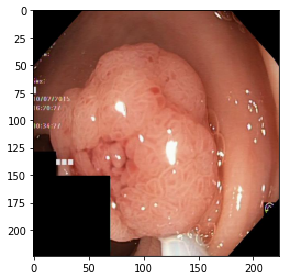

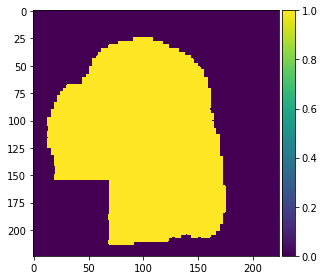

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [21]:
train_generator = zip(x, y)
valid_generator = zip(x_val, y_val)

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


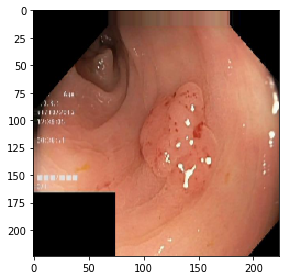

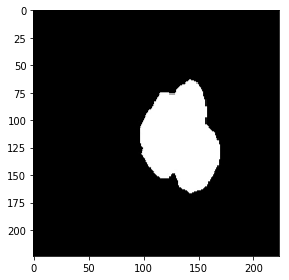

In [15]:
# from matplotlib import pyplot as plt
# %matplotlib inline

# imshow(image_generator.next()[10].astype(np.uint8))
# plt.show()
# imshow(np.squeeze(mask_generator.next()[10].astype(np.uint8)))
# plt.show()

In [30]:
from keras.metrics import binary_crossentropy

In [31]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [32]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [1]:
import efficientnet.keras as efn
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import LeakyReLU, Add, Input,MaxPool2D,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout
base_model = efn.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))


input_model = base_model.input
start_neurons = 8
dropout_ratio = 0.1

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x


conv5 = base_model.get_layer('top_activation').output
conv4 = base_model.get_layer('block6a_expand_activation').output
conv3 = base_model.get_layer('block4a_expand_activation').output
conv2 = base_model.get_layer('block3a_expand_activation').output
conv1 = base_model.get_layer('block2a_expand_activation').output

#Middle 7*7
convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(conv5)
convm = residual_block(convm,start_neurons * 32)
convm = residual_block(convm,start_neurons * 32)
convm = LeakyReLU(alpha=0.1)(convm) #7*7

#14*14
deconv4 = Conv2DTranspose(start_neurons*16,(3,3),strides=(2,2),padding="same")(convm)
uconv4 = concatenate([deconv4,conv4])
uconv4 = Dropout(dropout_ratio)(uconv4)
uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
uconv4 = residual_block(uconv4,start_neurons * 16)
uconv4 = LeakyReLU(alpha=0.1)(uconv4)

#28*28
deconv3 = Conv2DTranspose(start_neurons*8,(3,3),strides=(2,2),padding="same")(uconv4)
uconv3 = concatenate([deconv3,conv3])
uconv3 = Dropout(dropout_ratio)(uconv3)
uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
uconv3 = residual_block(uconv3,start_neurons * 8)
uconv3 = LeakyReLU(alpha=0.1)(uconv3)

#56*56
deconv2 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2,2),padding="same")(uconv3)
uconv2 = concatenate([deconv2,conv2])
uconv2 = Dropout(dropout_ratio)(uconv2)
uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
uconv2 = residual_block(uconv2,start_neurons * 4)
uconv2 = LeakyReLU(alpha=0.1)(uconv2)

#112*112
deconv1 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2,2),padding="same")(uconv2)
uconv1 = concatenate([deconv1,conv1])
uconv1 = Dropout(dropout_ratio)(uconv1)
uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
uconv1 = residual_block(uconv1,start_neurons * 2)
uconv1 = LeakyReLU(alpha=0.1)(uconv1)

#224*224
deconv0 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2,2),padding="same")(uconv1)
uconv0 = Dropout(dropout_ratio)(deconv0)
uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
uconv0 = residual_block(uconv0,start_neurons * 1)
uconv0 = LeakyReLU(alpha=0.1)(uconv0)

output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)

model = Model(input_model,[output_layer])
print(model.summary())


# layer_name = 'top_conv'
# # intermediate_layer_model = Model(inputs=model.input,outputs = model.get_layer(layer_name).output)
# # print(intermediate_layer_model.summary())
# conv = model.get_layer(layer_name).output


Using TensorFlow backend.
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poudelas/anaco

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [43]:
model.compile(optimizer=Adam(lr = 0.0001), loss=bce_dice_loss, metrics=[dice_coef])

In [44]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('Efficient_original.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [45]:
results = model.fit_generator(train_generator, validation_data=valid_generator, validation_steps=50, steps_per_epoch=100,
                              epochs=100, callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 36s 355ms/step - loss: 1.3028 - dice_coef: 0.3631 - val_loss: 0.7324 - val_dice_coef: 0.6247

Epoch 00001: val_loss improved from inf to 0.73238, saving model to Efficient_original.h5
Epoch 2/100
100/100 [==============================] - 17s 174ms/step - loss: 0.7840 - dice_coef: 0.5571 - val_loss: 0.5256 - val_dice_coef: 0.6928

Epoch 00002: val_loss improved from 0.73238 to 0.52562, saving model to Efficient_original.h5
Epoch 3/100
100/100 [==============================] - 17s 174ms/step - loss: 0.6557 - dice_coef: 0.6164 - val_loss: 0.5407 - val_dice_coef: 0.6891

Epoch 00003: val_loss did not improve from 0.52562
Epoch 4/100
100/100 [==============================] - 17s 174ms/step - loss: 0.5985 - dice_coef: 0.6377 - val_loss: 0.5672 - val_dice_coef: 0.6415

Epoch 00004: val_loss did not improve from 0.52562
Epoch 5/100
100/100 [==============================] - 17s 174ms/step - loss: 0.5271 - dice_coef: 0.6826 - val_loss: 0


Epoch 00036: val_loss did not improve from 0.27766
Epoch 37/100
100/100 [==============================] - 17s 173ms/step - loss: 0.1546 - dice_coef: 0.9084 - val_loss: 0.3012 - val_dice_coef: 0.8456

Epoch 00037: val_loss did not improve from 0.27766
Epoch 38/100
100/100 [==============================] - 17s 173ms/step - loss: 0.1528 - dice_coef: 0.9098 - val_loss: 0.2966 - val_dice_coef: 0.8492

Epoch 00038: val_loss did not improve from 0.27766
Epoch 00038: early stopping


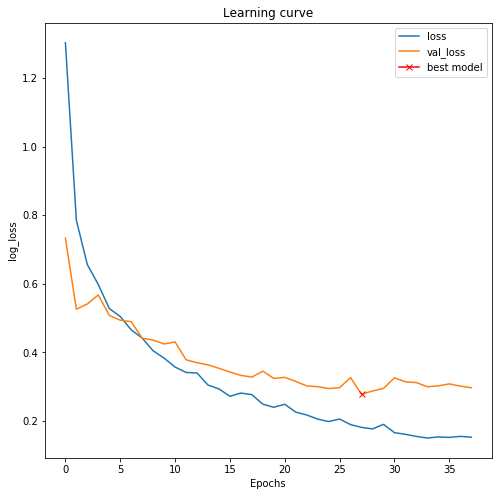

In [46]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [47]:
import sys
from tqdm import tqdm
TEST_PATH = '/home/poudelas/Documents/unet-master/data1/Kvasir-SEG/data/test1/'
test_ids = next(os.walk(TEST_PATH+'img'))[2]
X_test = np.zeros((len(test_ids), 224, 224, 3), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH + 'img/' + id_)[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (224, 224), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 105/105 [00:02<00:00, 38.90it/s]

Done!


In [49]:
# Load best model
model.load_weights('Efficient_original.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

105/105 [==============================] - 0s 4ms/step


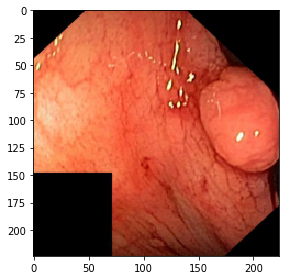

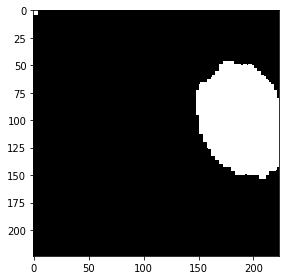

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


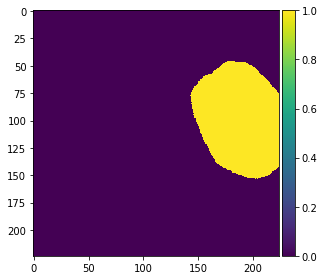

In [50]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

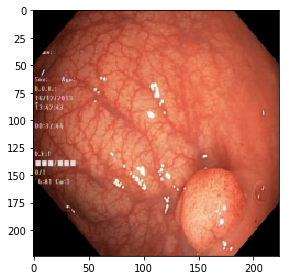

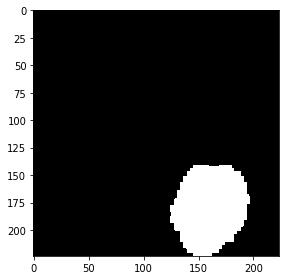

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


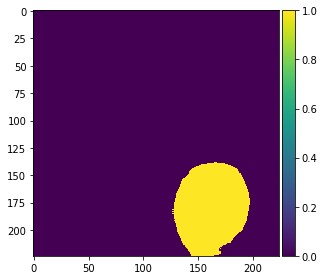

In [51]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [52]:
model.evaluate(X_valid, y_valid, verbose=1)

NameError: name 'X_valid' is not defined